**Generating Visual Embeddings for VisualBert**

Following the tutorial https://colab.research.google.com/drive/1bLGxKdldwqnMVA5x4neY7-l_8fKGWQYI?usp=sharing#scrollTo=643yOpAZwRWq.

In [1]:
import torch
torch.__version__

'2.2.1+cu121'

In [2]:
torch.cuda.is_available()

True

In [3]:
%%capture
#!pip install pyyaml==5.1
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' # because FastRCNNOutputs is not there anymore, they changed codebase
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'

In [4]:
import torch, torchvision
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from copy import deepcopy

In [5]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs # check this!
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg

In [6]:
# load image
from skimage.io import imshow
from skimage.io import imread
from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded))
#image = imshow(image_path)
# TO DO: HOW TO LOAD ALL FILES?

Saving 17031-flower04.jpg to 17031-flower04.jpg


**Installing Decetron 2**



Saving 32881-1tondo2.jpg to 32881-1tondo2.jpg
(1000, 1243, 3)
(1003, 1035, 3)


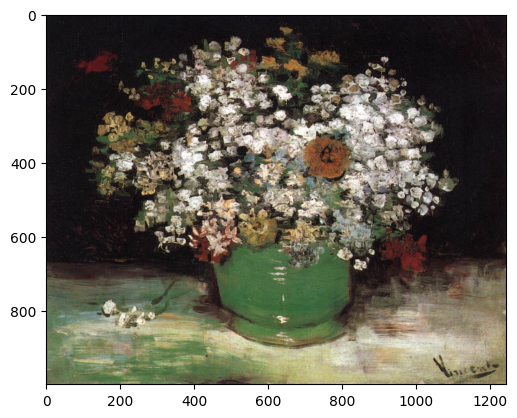

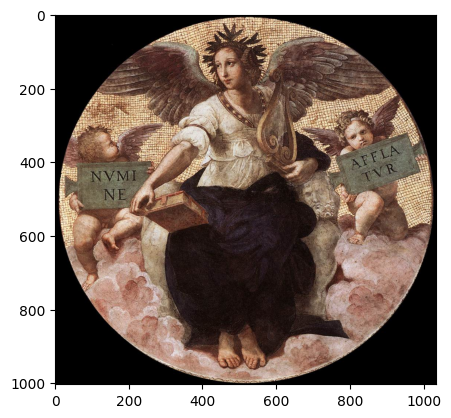

In [14]:
img1 = plt.imread(image_path)

# Detectron expects BGR images
img_bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)

# Let's use another image
uploaded = files.upload()
image_path2 = next(iter(uploaded))
img2 = plt.imread(image_path2)
img_bgr2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

print(img1.shape) # do all images have the same shape? --> No! Only third dimension (colour channels) = 3 obv
print(img2.shape)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

**Load Config and Model Weights**


In [10]:
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

def load_config_and_model_weights(cfg_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
    cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path)

### Load the Object Detection Model
The `build_model` method can be used to load a model from the configuration, the checkpoints have to be loaded using the `DetetionCheckpointer`.

In [11]:
def get_model(cfg):
    # build model
    model = build_model(cfg)

    # load weights
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    # eval mode
    model.eval()
    return model

model = get_model(cfg)

model_final_a3ec72.pkl: 254MB [00:02, 95.6MB/s]                           
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


### Convert Image to Model Input
The detectron uses resizing and normalization based on the configuration parameters and the input is to be provided using `ImageList`. The `model.backbone.size_divisibility` handles the sizes (padding) such that the FPN lateral and output convolutional features have same dimensions.

In [15]:
def prepare_image_inputs(cfg, img_list):
    # Resizing the image according to the configuration
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1))

    batched_inputs = [{"image":convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]} for img in img_list]

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1)
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1)
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    images = [normalizer(x["image"]) for x in batched_inputs]

    # Convert to ImageList
    images =  ImageList.from_tensors(images,model.backbone.size_divisibility)

    return images, batched_inputs

images, batched_inputs = prepare_image_inputs(cfg, [img_bgr1, img_bgr2]) # I only used one image so far, Here you can give all images as list!



### Get ResNet+FPN features
The ResNet model in combination with FPN generates five features for an image at different levels of complexity. For more details, refer to the FPN paper or this [article](https://medium.com/@hirotoschwert/digging-into-detectron-2-47b2e794fabd). For this tutorial, just know that `p2`, `p3`, `p4`, `p5`, `p6` are the features needed by the RPN (Region Proposal Network). The proposals in combination with `p2`, `p3`, `p4`, `p5` are then used by the ROI (Region of Interest) heads to generate box predictions.

In [16]:
def get_features(model, images):
    features = model.backbone(images.tensor)
    return features

features = get_features(model, images)

In [17]:
features.keys()

dict_keys(['p2', 'p3', 'p4', 'p5', 'p6'])

### Visualizing Image and Image features
Just for a sanity check, we visualize the 0th channels in each of the features, and their shapes.

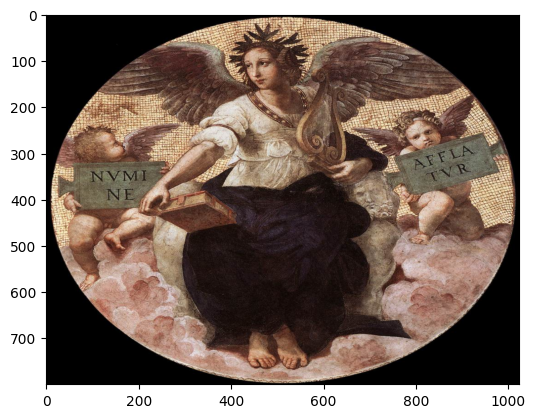

torch.Size([2, 256, 200, 256])


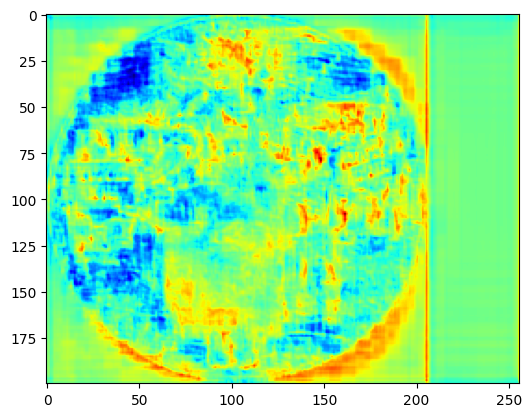

torch.Size([2, 256, 100, 128])


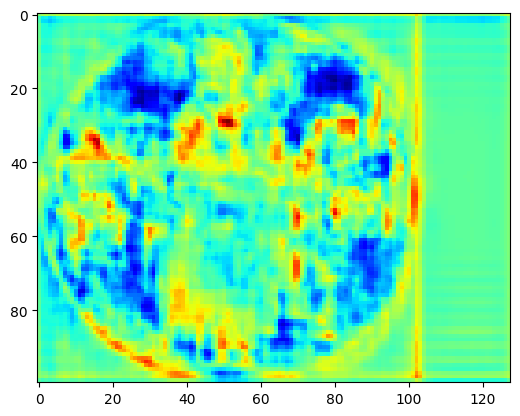

torch.Size([2, 256, 50, 64])


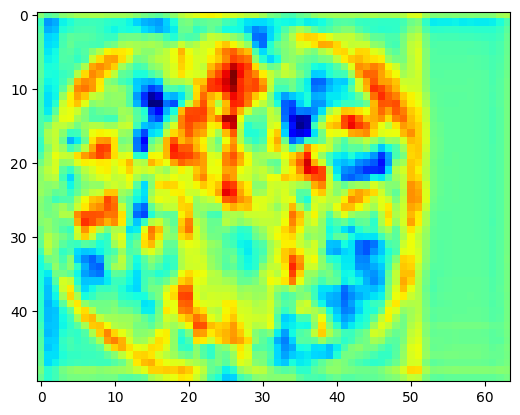

torch.Size([2, 256, 25, 32])


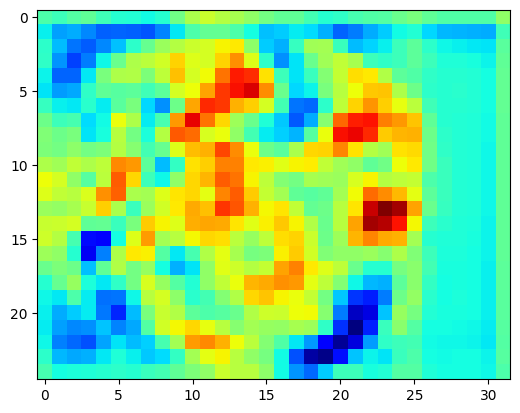

torch.Size([2, 256, 13, 16])


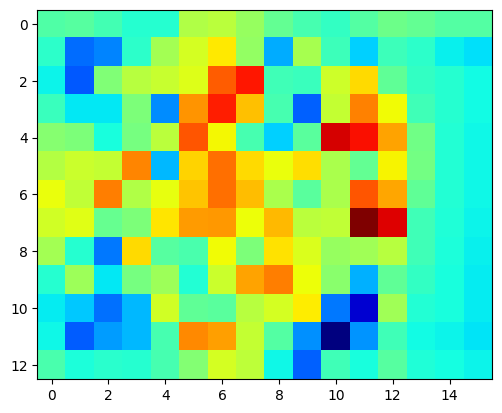

In [18]:
plt.imshow(cv2.resize(img2, (images.tensor.shape[-2:][::-1])))
plt.show()
for key in features.keys():
    print(features[key].shape)
    plt.imshow(features[key][1,0,:,:].squeeze().detach().numpy(), cmap='jet')
    plt.show()

### Get region proposals from RPN
This RPN takes in the features and images and generates the proposals. Based on the configuration we chose, we get 1000 proposals.

In [19]:
def get_proposals(model, images, features):
    proposals, _ = model.proposal_generator(images, features)
    return proposals

proposals = get_proposals(model, images, features)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Get Box Features for the proposals

The proposals and features are then used by the ROI heads to get the predictions. In this case, the partial execution of layers becomes significant. We want the `box_features` to be the `fc2` outputs of the regions. Hence, I use only the layers that are needed until that step.

In [20]:
def get_box_features(model, features, proposals):
    features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
    box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head.flatten(box_features)
    box_features = model.roi_heads.box_head.fc1(box_features)
    box_features = model.roi_heads.box_head.fc_relu1(box_features)
    box_features = model.roi_heads.box_head.fc2(box_features)

    box_features = box_features.reshape(2, 1000, 1024) # depends on your config and batch size
    return box_features, features_list

box_features, features_list = get_box_features(model, features, proposals)

### Get prediction logits and boxes
The prediction class logits and the box predictions from the ROI heads, this is used in the next step to get the boxes and scores from the `FastRCNNOutputs`


In [21]:
def get_prediction_logits(model, features_list, proposals):
    cls_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    cls_features = model.roi_heads.box_head(cls_features)
    pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(cls_features)
    return pred_class_logits, pred_proposal_deltas

pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)

### Get FastRCNN scores and boxes

This results in the softmax scores and the boxes.

In [22]:
def get_box_scores(cfg, pred_class_logits, pred_proposal_deltas):
    box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA

    outputs = FastRCNNOutputs(
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta,
    )

    boxes = outputs.predict_boxes()
    scores = outputs.predict_probs()
    image_shapes = outputs.image_shapes

    return boxes, scores, image_shapes

boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas)

In [23]:
boxes

(tensor([[349.0373, 382.1614, 662.4983,  ..., 429.1370, 657.2620, 706.3915],
         [ 85.8769,  69.2391, 797.4563,  ...,  85.7349, 808.7543, 684.4872],
         [154.7205, 185.0449, 719.6315,  ..., 205.6133, 666.8124, 698.8658],
         ...,
         [ 88.8285, 288.1972, 190.7028,  ..., 294.8060, 195.1705, 404.4503],
         [693.7158, 458.9077, 809.7852,  ..., 464.8248, 797.6982, 622.4031],
         [181.9098, 361.9361, 241.3892,  ..., 361.2880, 240.3799, 425.9560]],
        grad_fn=<SplitWithSizesBackward0>),
 tensor([[ 64.4520,  42.9886, 613.5909,  ...,  68.4128, 663.0277, 666.5795],
         [294.0252,  54.9604, 800.5067,  ...,  80.2736, 797.9985, 740.0698],
         [135.0510,  51.0547, 665.6960,  ...,  66.9144, 745.6623, 689.7606],
         ...,
         [609.2786, 363.3674, 629.3816,  ..., 362.1704, 630.0672, 388.3677],
         [ 12.6825,  97.1883, 214.2608,  ...,  46.5446, 206.9231, 707.5774],
         [514.6966, 186.8789, 543.7907,  ..., 189.2006, 543.5120, 224.4404]],
  

### Rescale the boxes to original image size
We want to rescale the boxes to original size as this is done in the detectron2 library. This is done for sanity and to keep it similar to the visualbert repository.

In [24]:
def get_output_boxes(boxes, batched_inputs, image_size):
    proposal_boxes = boxes.reshape(-1, 4).clone()
    scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
    output_boxes = Boxes(proposal_boxes)

    output_boxes.scale(scale_x, scale_y)
    output_boxes.clip(image_size)

    return output_boxes

output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]

### Select the Boxes using NMS
We need two thresholds - NMS threshold for the NMS box section, and score threshold for the score based section.

First NMS is performed for all the classes and the max scores of each proposal box and each class is updated.

Then the class score threshold is used to select the boxes from those.

In [25]:
def select_boxes(cfg, output_boxes, scores):
    test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cls_prob = scores.detach()
    cls_boxes = output_boxes.tensor.detach().reshape(1000,80,4)
    max_conf = torch.zeros((cls_boxes.shape[0]))
    for cls_ind in range(0, cls_prob.shape[1]-1):
        cls_scores = cls_prob[:, cls_ind+1]
        det_boxes = cls_boxes[:,cls_ind,:]
        keep = np.array(nms(det_boxes, cls_scores, test_nms_thresh))
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])
    keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
    return keep_boxes, max_conf

In [26]:
temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
keep_boxes, max_conf = [],[]
for keep_box, mx_conf in temp:
    keep_boxes.append(keep_box)
    max_conf.append(mx_conf)

### Limit the total number of boxes
In order to get the box features for the best few proposals and limit the sequence length, we set minimum and maximum boxes and pick those box features.



In [27]:
MIN_BOXES=10
MAX_BOXES=100
def filter_boxes(keep_boxes, max_conf, min_boxes, max_boxes):
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:max_boxes]
    return keep_boxes

keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]

### Get the visual embeddings :)
Finally, the boxes are chosen using the `keep_boxes` indices and from the `box_features` tensor.

In [28]:
def get_visual_embeds(box_features, keep_boxes):
    return box_features[keep_boxes.copy()]

visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]

In [35]:
visual_embeds # list of tensors
print(len(visual_embeds)) # number of images
print(visual_embeds[1].shape) # images have now the same shape! So I have a list of tensors of shape 100,1024

2
torch.Size([100, 1024])


Now I can use the embeddings to pass it to vilbert and to use them as input for a classifier MLP.